In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [18]:
def load_image_data(data_dir, classes, img_height, img_width, channels):
    X = []
    y = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = plt.imread(img_path)
                img = np.resize(img, (img_height, img_width, channels))
                X.append(img)
                y.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y

# Parameters
data_dir = "D:\AIML\Autism_Detection_Project\dataset\images"
classes = ['Control', 'ASD']
img_height, img_width, channels = 128, 128, 3

# Load data
X, y = load_image_data(data_dir, classes, img_height, img_width, channels)
print(f"Total samples: {X.shape[0]}")
print(f"Image shape: {X.shape[1:]}")
print(f"Labels distribution: {np.bincount(y)}")


Total samples: 2940
Image shape: (128, 128, 3)
Labels distribution: [1470 1470]


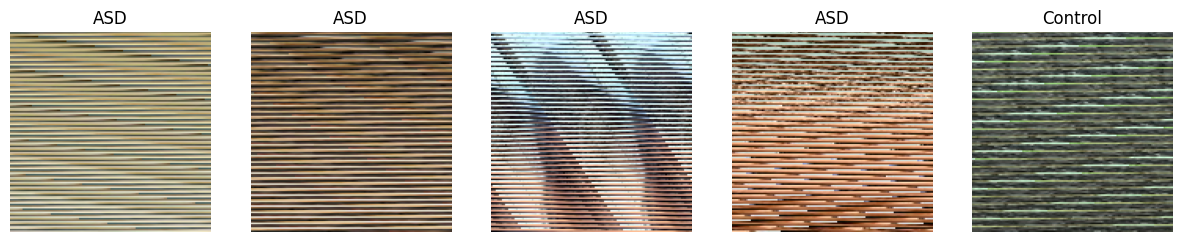

In [19]:
def plot_sample_images(X, y, classes, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, X.shape[0])
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X[idx])
        plt.title(classes[y[idx]])
        plt.axis('off')
    plt.show()

plot_sample_images(X, y, classes)


In [20]:
# Normalize pixel values
X = X.astype('float32') / 255.0

# Train-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")


Training set: (2058, 128, 128, 3), (2058,)
Validation set: (441, 128, 128, 3), (441,)
Testing set: (441, 128, 128, 3), (441,)


In [21]:
# Reshape for SMOTE if using image data
X_train_res = X_train.reshape(X_train.shape[0], -1)
X_val_res = X_val.reshape(X_val.shape[0], -1)
X_test_res = X_test.reshape(X_test.shape[0], -1)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_res, y_train)

# Reshape back to image format
X_train_res = X_train_res.reshape(-1, img_height, img_width, channels)
print(f"After SMOTE, training set shape: {X_train_res.shape}, {y_train_res.shape}")


After SMOTE, training set shape: (2058, 128, 128, 3), (2058,)


In [22]:
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

datagen.fit(X_train_res)


In [23]:
def build_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

input_shape = (img_height, img_width, channels)
cnn_model = build_cnn_model(input_shape)
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 64)      

In [24]:
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/best_cnn_model.h5', monitor='val_loss', save_best_only=True)


In [27]:
batch_size = 32
epochs = 30

history = cnn_model.fit(
    datagen.flow(X_train_res, y_train_res, batch_size=batch_size),
    steps_per_epoch=len(X_train_res) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint]
)


Epoch 1/30
64/64 [==============================] - 52s 819ms/step - loss: 0.8282 - accuracy: 0.5913 - val_loss: 2.0894 - val_accuracy: 0.4989
Epoch 2/30
64/64 [==============================] - 51s 787ms/step - loss: 0.7916 - accuracy: 0.6012 - val_loss: 3.0862 - val_accuracy: 0.4989
Epoch 3/30
64/64 [==============================] - 47s 730ms/step - loss: 0.7538 - accuracy: 0.6032 - val_loss: 1.9499 - val_accuracy: 0.4989
Epoch 4/30
64/64 [==============================] - 48s 742ms/step - loss: 0.7205 - accuracy: 0.5938 - val_loss: 0.9529 - val_accuracy: 0.5057
Epoch 5/30
64/64 [==============================] - 46s 731ms/step - loss: 0.6745 - accuracy: 0.6367 - val_loss: 0.7040 - val_accuracy: 0.5488
Epoch 6/30
64/64 [==============================] - 52s 809ms/step - loss: 0.6663 - accuracy: 0.6392 - val_loss: 0.7287 - val_accuracy: 0.5624
Epoch 7/30
64/64 [==============================] - 50s 773ms/step - loss: 0.6846 - accuracy: 0.6288 - val_loss: 0.8339 - val_accuracy: 0.5488

14/14 [==============================] - 3s 169ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       221
           1       0.67      0.60      0.63       220

    accuracy                           0.65       441
   macro avg       0.65      0.65      0.65       441
weighted avg       0.65      0.65      0.65       441

Confusion Matrix:
[[154  67]
 [ 87 133]]


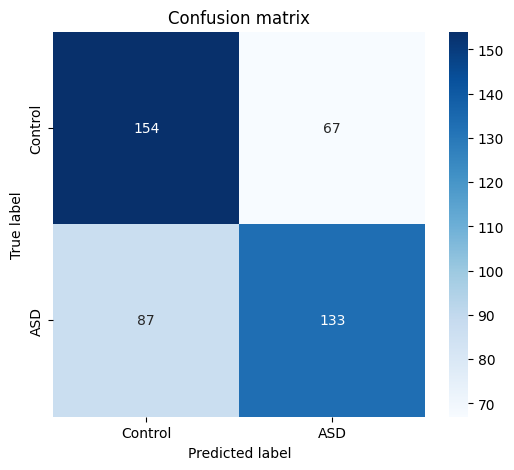

In [28]:
# Load the best model
best_cnn_model = models.load_model('models/best_cnn_model.h5')

# Predict on test data
y_pred_prob = best_cnn_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('plots/confusion_matrix.png')
    plt.show()

plot_confusion_matrix(cm, classes=classes)


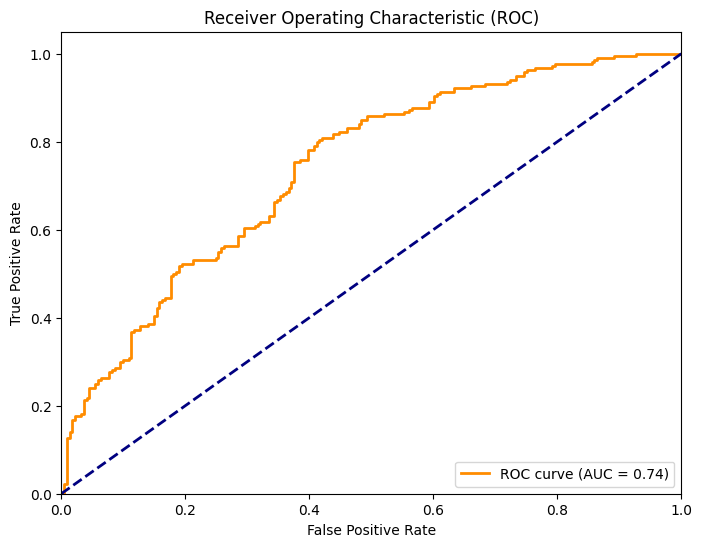

In [30]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('plots/roc_curve.png')
plt.show()


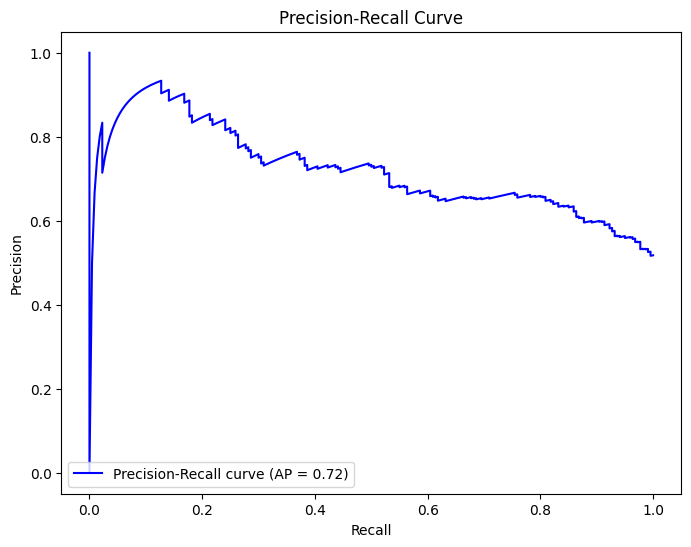

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve and Average Precision
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='b', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('plots/precision_recall_curve.png')
plt.show()


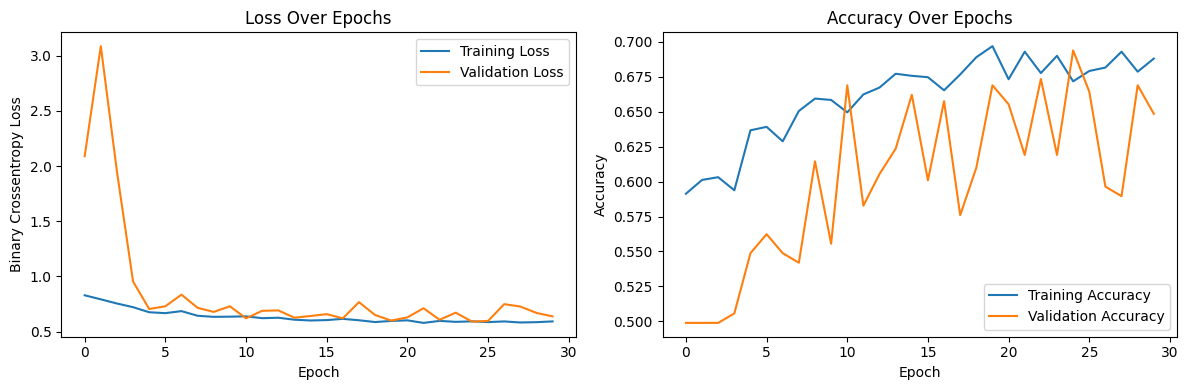

In [32]:
def plot_training_history(history):
    plt.figure(figsize=(12,4))
    
    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('plots/training_history.png')
    plt.show()

plot_training_history(history)


In [33]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate F1-Score, Precision, and Recall
f1 = f1_score(y_test, y_pred)
precision_val = precision_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)

print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")


F1-Score: 0.6333
Precision: 0.6650
Recall: 0.6045


In [34]:
# Save the final model
simplified_cnn_model.save('models/cnn_model_final.h5')
print("Final CNN model saved successfully!")


Final CNN model saved successfully!
